<h2>Mounting google drive</h2>

In [1]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
!unzip -q "/content/gdrive/My Drive/hvc_data.zip"
# look for `hvc_annotations.csv` file and `resized` dir
%ls 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
gdrive/  hvc_annotations.csv  resized/  sample_data/


<h2>Importing basic packages</h2>

In [2]:
%tensorflow_version 1.x

import cv2
import json

import numpy as np
import pandas as pd

from functools import partial
from pathlib import Path 
from tqdm import tqdm

from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from keras.layers import Dense, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.layers import AveragePooling2D, Input, Flatten, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.regularizers import l2
from keras.applications import VGG16, ResNet50
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import SGD, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import *
from keras.applications.resnet50 import preprocess_input


Using TensorFlow backend.


In [0]:
# load annotations
df = pd.read_csv("hvc_annotations.csv")
del df["filename"] # remove unwanted column

<h2>Some Analysis of the number of diffferent subclasses</h2>

In [4]:
df.head()

,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
0,male,Average,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Front-Frontish,resized/1.jpg
1,female,Average,35-45,over-weight,None,Normal,Angry/Serious,Front-Frontish,resized/2.jpg
2,male,Good,45-55,normal-healthy,Grocery/Home/Plastic Bag,CantSee,Neutral,Front-Frontish,resized/3.jpg
3,male,Good,45-55,normal-healthy,Daily/Office/Work Bag,Normal,Neutral,Front-Frontish,resized/4.jpg
4,female,Good,35-45,slightly-overweight,None,CantSee,Neutral,Front-Frontish,resized/5.jpg


In [5]:
df['imagequality'].value_counts()

Average    7509
Good       3824
Bad        2240
Name: imagequality, dtype: int64

In [6]:
df['age'].value_counts()

25-35    5411
35-45    3435
15-25    2494
45-55    1490
55+       743
Name: age, dtype: int64

In [7]:
df['weight'].value_counts()

normal-healthy         8628
slightly-overweight    3196
over-weight             891
underweight             858
Name: weight, dtype: int64

In [8]:
df['carryingbag'].value_counts()

None                        7649
Daily/Office/Work Bag       4603
Grocery/Home/Plastic Bag    1321
Name: carryingbag, dtype: int64

In [9]:
df['footwear'].value_counts()

Normal     6038
CantSee    5028
Fancy      2507
Name: footwear, dtype: int64

In [10]:
df['emotion'].value_counts()

Neutral          9660
Happy            1609
Angry/Serious    1500
Sad               804
Name: emotion, dtype: int64

In [11]:
df['bodypose'].value_counts()

Front-Frontish    8383
Side              2983
Back              2207
Name: bodypose, dtype: int64

<h2>Converting image tags to one hot encoding per class</h2>

In [12]:
# one hot encoding of labels

one_hot_df = pd.concat([
    df[["image_path"]],
    pd.get_dummies(df.gender, prefix="gender"),
    pd.get_dummies(df.imagequality, prefix="imagequality"),
    pd.get_dummies(df.age, prefix="age"),
    pd.get_dummies(df.weight, prefix="weight"),
    pd.get_dummies(df.carryingbag, prefix="carryingbag"),
    pd.get_dummies(df.footwear, prefix="footwear"),
    pd.get_dummies(df.emotion, prefix="emotion"),
    pd.get_dummies(df.bodypose, prefix="bodypose"),
], axis = 1)

one_hot_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,13533,13534,13535,13536,13537,13538,13539,13540,13541,13542,13543,13544,13545,13546,13547,13548,13549,13550,13551,13552,13553,13554,13555,13556,13557,13558,13559,13560,13561,13562,13563,13564,13565,13566,13567,13568,13569,13570,13571,13572
image_path,resized/1.jpg,resized/2.jpg,resized/3.jpg,resized/4.jpg,resized/5.jpg,resized/6.jpg,resized/7.jpg,resized/8.jpg,resized/9.jpg,resized/10.jpg,resized/11.jpg,resized/12.jpg,resized/13.jpg,resized/14.jpg,resized/15.jpg,resized/16.jpg,resized/17.jpg,resized/18.jpg,resized/19.jpg,resized/20.jpg,resized/21.jpg,resized/22.jpg,resized/23.jpg,resized/24.jpg,resized/25.jpg,resized/26.jpg,resized/27.jpg,resized/28.jpg,resized/29.jpg,resized/30.jpg,resized/31.jpg,resized/32.jpg,resized/33.jpg,resized/34.jpg,resized/35.jpg,resized/36.jpg,resized/37.jpg,resized/38.jpg,resized/39.jpg,resized/40.jpg,...,resized/13535.jpg,resized/13536.jpg,resized/13537.jpg,resized/13538.jpg,resized/13539.jpg,resized/13540.jpg,resized/13541.jpg,resized/13542.jpg,resized/13543.jpg,resized/13544.jpg,resized/13545.jpg,resized/13546.jpg,resized/13547.jpg,resized/13548.jpg,resized/13549.jpg,resized/13550.jpg,resized/13551.jpg,resized/13552.jpg,resized/13553.jpg,resized/13554.jpg,resized/13555.jpg,resized/13556.jpg,resized/13557.jpg,resized/13558.jpg,resized/13559.jpg,resized/13560.jpg,resized/13561.jpg,resized/13562.jpg,resized/13563.jpg,resized/13564.jpg,resized/13565.jpg,resized/13566.jpg,resized/13567.jpg,resized/13568.jpg,resized/13569.jpg,resized/13570.jpg,resized/13571.jpg,resized/13572.jpg,resized/13573.jpg,resized/13574.jpg
gender_female,0,1,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,1,0,1,0,0,1,1,0,1,...,1,1,1,0,0,1,1,1,0,0,1,1,0,1,1,1,0,0,1,1,0,0,1,1,1,1,0,0,1,1,0,1,1,1,1,0,1,1,1,0
gender_male,1,0,1,1,0,1,1,1,1,1,0,1,1,0,0,1,1,1,1,1,1,1,0,1,1,0,1,1,0,1,0,0,1,0,1,1,0,0,1,0,...,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,1,1,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,1
imagequality_Average,1,1,0,0,0,0,0,0,1,1,1,1,0,0,1,1,0,0,1,0,1,0,1,1,0,1,1,0,0,1,0,0,1,0,1,0,0,0,1,0,...,1,1,1,0,1,1,0,0,1,0,0,1,0,1,0,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,1,0,0,0
imagequality_Bad,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,1,...,0,0,0,1,0,0,1,1,0,1,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0
imagequality_Good,0,0,1,1,1,1,0,1,0,0,0,0,1,1,0,0,1,1,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
age_15-25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
age_25-35,0,0,0,0,0,0,1,1,0,1,0,0,0,1,1,1,0,0,1,0,0,0,1,1,0,1,1,1,0,0,0,1,0,0,1,0,1,0,1,1,...,0,1,0,0,1,1,1,0,0,1,0,1,1,0,0,0,0,0,0,1,0,1,0,1,1,1,1,1,0,0,1,1,0,0,1,0,1,0,1,1
age_35-45,1,1,0,0,1,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,1,0,0,...,0,0,1,1,0,0,0,1,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0
age_45-55,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


<h2>Creating train and test splits</h2>

In [13]:
one_hot_df.columns

Index(['image_path', 'gender_female', 'gender_male', 'imagequality_Average',
       'imagequality_Bad', 'imagequality_Good', 'age_15-25', 'age_25-35',
       'age_35-45', 'age_45-55', 'age_55+', 'weight_normal-healthy',
       'weight_over-weight', 'weight_slightly-overweight',
       'weight_underweight', 'carryingbag_Daily/Office/Work Bag',
       'carryingbag_Grocery/Home/Plastic Bag', 'carryingbag_None',
       'footwear_CantSee', 'footwear_Fancy', 'footwear_Normal',
       'emotion_Angry/Serious', 'emotion_Happy', 'emotion_Neutral',
       'emotion_Sad', 'bodypose_Back', 'bodypose_Front-Frontish',
       'bodypose_Side'],
      dtype='object')

In [14]:
len(one_hot_df.columns)

28

In [15]:
a = [col for col in one_hot_df.columns if col.startswith("gender")]
a

['gender_female', 'gender_male']

In [0]:
import keras
import numpy as np

# Label columns per attribute
_gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
_imagequality_cols_ = [col for col in one_hot_df.columns if col.startswith("imagequality")]
_age_cols_ = [col for col in one_hot_df.columns if col.startswith("age")]
_weight_cols_ = [col for col in one_hot_df.columns if col.startswith("weight")]
_carryingbag_cols_ = [col for col in one_hot_df.columns if col.startswith("carryingbag")]
_footwear_cols_ = [col for col in one_hot_df.columns if col.startswith("footwear")]
_emotion_cols_ = [col for col in one_hot_df.columns if col.startswith("emotion")]
_bodypose_cols_ = [col for col in one_hot_df.columns if col.startswith("bodypose")]

class PersonDataGenerator(keras.utils.Sequence):
    """Ground truth data generator"""

    def __init__(self, df, batch_size=128, shuffle=True, augmentation=None):
        self.df = df
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        self.augmentation = augmentation

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        """fetch batched images and targets"""
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        items = self.df.iloc[batch_slice]
        
        images = np.stack([cv2.imread(item["image_path"]) for _, item in items.iterrows()])
        images = preprocess_input(images)
        images= images/np.std(images)

        if self.augmentation is not None:
            images = self.augmentation.flow(images, shuffle=False).next()
        
        target = {
            "gender_output": items[_gender_cols_].values,
            "image_quality_output": items[_imagequality_cols_].values,
            "age_output": items[_age_cols_].values,
            "weight_output": items[_weight_cols_].values,
            "bag_output": items[_carryingbag_cols_].values,
            "pose_output": items[_bodypose_cols_].values,
            "footwear_output": items[_footwear_cols_].values,
            "emotion_output": items[_emotion_cols_].values,
        }
        
        return images, target

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)




In [0]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(one_hot_df, test_size=0.15, random_state=1)


In [18]:
train_df.T

,58,2106,5206,1163,13534,806,4357,10439,2102,9668,1463,10617,10473,10182,6640,10964,7637,6087,2144,8618,12664,8196,13077,12661,923,6209,7403,10536,10114,4071,5102,1291,13473,1555,569,1595,9098,7140,5585,1271,...,3606,2877,4415,1031,6121,6285,1110,1888,11742,9719,753,3049,8151,10820,562,6542,8093,4764,3562,8444,2516,2962,12645,5374,5396,9394,3462,10989,7751,4225,144,5056,2895,7813,10955,905,5192,12172,235,13349
image_path,resized/59.jpg,resized/2107.jpg,resized/5207.jpg,resized/1164.jpg,resized/13536.jpg,resized/807.jpg,resized/4358.jpg,resized/10441.jpg,resized/2103.jpg,resized/9669.jpg,resized/1464.jpg,resized/10619.jpg,resized/10475.jpg,resized/10184.jpg,resized/6641.jpg,resized/10966.jpg,resized/7638.jpg,resized/6088.jpg,resized/2145.jpg,resized/8619.jpg,resized/12666.jpg,resized/8197.jpg,resized/13079.jpg,resized/12663.jpg,resized/924.jpg,resized/6210.jpg,resized/7404.jpg,resized/10538.jpg,resized/10115.jpg,resized/4072.jpg,resized/5103.jpg,resized/1292.jpg,resized/13475.jpg,resized/1556.jpg,resized/570.jpg,resized/1596.jpg,resized/9099.jpg,resized/7141.jpg,resized/5586.jpg,resized/1272.jpg,...,resized/3607.jpg,resized/2878.jpg,resized/4416.jpg,resized/1032.jpg,resized/6122.jpg,resized/6286.jpg,resized/1111.jpg,resized/1889.jpg,resized/11744.jpg,resized/9720.jpg,resized/754.jpg,resized/3050.jpg,resized/8152.jpg,resized/10822.jpg,resized/563.jpg,resized/6543.jpg,resized/8094.jpg,resized/4765.jpg,resized/3563.jpg,resized/8445.jpg,resized/2517.jpg,resized/2963.jpg,resized/12647.jpg,resized/5375.jpg,resized/5397.jpg,resized/9395.jpg,resized/3463.jpg,resized/10991.jpg,resized/7752.jpg,resized/4226.jpg,resized/145.jpg,resized/5057.jpg,resized/2896.jpg,resized/7814.jpg,resized/10957.jpg,resized/906.jpg,resized/5193.jpg,resized/12174.jpg,resized/236.jpg,resized/13351.jpg
gender_female,0,1,0,1,1,0,1,1,0,0,1,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,1,1,0,1,0,1,0,0,0,1,0,0,1,1,...,1,1,0,0,1,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,1,0,0,1,0,1,0,0
gender_male,1,0,1,0,0,1,0,0,1,1,0,1,1,1,0,0,1,1,1,0,0,1,1,0,1,1,0,0,1,0,1,0,1,1,1,0,1,1,0,0,...,0,0,1,1,0,1,1,1,0,0,1,1,1,1,0,0,1,1,1,1,1,0,1,1,1,1,0,1,0,1,1,0,0,1,1,0,1,0,1,1
imagequality_Average,0,0,1,1,1,0,0,0,1,1,0,1,0,0,1,1,1,1,1,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,...,1,0,1,0,0,1,0,1,1,1,1,1,1,1,1,0,0,1,1,1,0,1,0,0,0,1,0,1,1,0,1,0,0,0,1,1,1,0,0,1
imagequality_Bad,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,1,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
imagequality_Good,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,1,1,0,1,0,0,0,0,1,0,0,...,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,1,1,1,0,0,0,0,1,0,1,1,0,0,0,0,1,1,0
age_15-25,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,1,1,...,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
age_25-35,0,0,0,1,1,0,1,1,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,1,0,1,0,1,0,0,0,1,0,0,1,0,0,0,...,1,1,0,1,1,0,0,0,1,1,1,1,0,1,1,0,0,0,1,0,0,1,1,0,0,0,1,0,0,1,1,1,1,1,0,1,0,1,0,0
age_35-45,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0
age_45-55,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1


In [19]:
val_df.T

,2450,2743,12207,3931,994,8165,2784,2247,35,8514,2416,11904,7030,1520,368,153,4165,11790,2740,11225,11483,687,2330,2560,5779,10938,2621,7281,11902,7840,9693,2320,12958,1282,9765,6910,13296,5921,9545,6192,...,2973,8268,5910,13235,4844,7943,12137,370,4406,12266,3401,9237,2422,1868,8385,7048,82,6638,12774,5193,10596,7369,7781,6416,7226,8465,4246,7485,4876,5118,10241,11732,1933,7342,11701,5812,7443,8678,9231,8835
image_path,resized/2451.jpg,resized/2744.jpg,resized/12209.jpg,resized/3932.jpg,resized/995.jpg,resized/8166.jpg,resized/2785.jpg,resized/2248.jpg,resized/36.jpg,resized/8515.jpg,resized/2417.jpg,resized/11906.jpg,resized/7031.jpg,resized/1521.jpg,resized/369.jpg,resized/154.jpg,resized/4166.jpg,resized/11792.jpg,resized/2741.jpg,resized/11227.jpg,resized/11485.jpg,resized/688.jpg,resized/2331.jpg,resized/2561.jpg,resized/5780.jpg,resized/10940.jpg,resized/2622.jpg,resized/7282.jpg,resized/11904.jpg,resized/7841.jpg,resized/9694.jpg,resized/2321.jpg,resized/12960.jpg,resized/1283.jpg,resized/9766.jpg,resized/6911.jpg,resized/13298.jpg,resized/5922.jpg,resized/9546.jpg,resized/6193.jpg,...,resized/2974.jpg,resized/8269.jpg,resized/5911.jpg,resized/13237.jpg,resized/4845.jpg,resized/7944.jpg,resized/12139.jpg,resized/371.jpg,resized/4407.jpg,resized/12268.jpg,resized/3402.jpg,resized/9238.jpg,resized/2423.jpg,resized/1869.jpg,resized/8386.jpg,resized/7049.jpg,resized/83.jpg,resized/6639.jpg,resized/12776.jpg,resized/5194.jpg,resized/10598.jpg,resized/7370.jpg,resized/7782.jpg,resized/6417.jpg,resized/7227.jpg,resized/8466.jpg,resized/4247.jpg,resized/7486.jpg,resized/4877.jpg,resized/5119.jpg,resized/10243.jpg,resized/11734.jpg,resized/1934.jpg,resized/7343.jpg,resized/11703.jpg,resized/5813.jpg,resized/7444.jpg,resized/8679.jpg,resized/9232.jpg,resized/8836.jpg
gender_female,1,1,1,1,1,0,1,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,1,1,0,0,0,1,0,1,0,1,1,0,...,1,1,1,0,0,1,1,1,0,0,1,0,1,0,1,0,0,0,0,0,0,1,1,1,0,0,0,1,1,1,0,1,1,1,1,1,0,1,1,0
gender_male,0,0,0,0,0,1,0,1,1,1,1,0,1,1,1,0,0,1,1,0,1,1,1,1,1,1,1,0,0,0,1,1,1,0,1,0,1,0,0,1,...,0,0,0,1,1,0,0,0,1,1,0,1,0,1,0,1,1,1,1,1,1,0,0,0,1,1,1,0,0,0,1,0,0,0,0,0,1,0,0,1
imagequality_Average,1,1,0,1,1,1,1,1,0,1,0,0,1,0,0,1,1,0,1,0,0,1,1,0,1,0,1,1,0,1,0,1,0,1,0,0,1,1,1,1,...,0,1,1,1,0,0,0,0,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,0,1,1,0,1,0,0,0,1,0,0,1,0,0,1,1,0
imagequality_Bad,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1
imagequality_Good,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,1,0,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0
age_15-25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,1,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
age_25-35,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,1,0,1,1,1,1,0,1,0,1,1,1,0,0,1,1,1,0,0,0,...,0,0,1,0,1,1,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,0,0,1,1,0
age_35-45,1,1,0,1,0,0,1,1,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,...,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
age_45-55,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [20]:
train_df.shape, val_df.shape

((11537, 28), (2036, 28))

In [0]:
# create train and validation data generators
# train_gen = PersonDataGenerator(train_df, batch_size=32)
train_gen = PersonDataGenerator(
    train_df, 
    batch_size=32, 
    augmentation=ImageDataGenerator(
        horizontal_flip=True,
    )
)
valid_gen = PersonDataGenerator(val_df, batch_size=32, shuffle=False)

In [22]:
# get number of output units from data
images, targets = next(iter(train_gen))
num_units = { k.split("_output")[0]:v.shape[1] for k, v in targets.items()}
num_units

{'age': 5,
 'bag': 3,
 'emotion': 4,
 'footwear': 3,
 'gender': 2,
 'image_quality': 3,
 'pose': 3,
 'weight': 4}

<h2>Model Used - Resnet</h2>

In [0]:
# visible = Input(shape=(224,224,3))

# #Block 1
# conv1 = Conv2D(32, kernel_size=3, activation='relu',use_bias=False)(visible) #222
# conv1_bn = BatchNormalization()(conv1)
# conv1_d = Dropout(0.1)(conv1_bn)

# #Block 2
# conv2 = Conv2D(32, kernel_size=3, activation='relu',use_bias=False)(conv1_d) #220
# conv2_bn = BatchNormalization()(conv2)
# conv2_d = Dropout(0.1)(conv2_bn)


# pool1 = MaxPooling2D(pool_size=(2, 2))(conv2_d) #110

# #Block 3
# conv3 = Conv2D(64, kernel_size=3, activation='relu',use_bias=False)(pool1) #108
# conv3_bn = BatchNormalization()(conv3)
# conv3_d = Dropout(0.1)(conv3_bn)

# pool2 = MaxPooling2D(pool_size=(2, 2))(conv3_d) #54

# neck = Conv2D(128, kernel_size=3, activation='relu')(pool2)
# # neck = MaxPooling2D(pool_size=(2, 2))(conv2)


# # neck = backbone.output
# neck = Flatten(name="flatten")(neck)
# neck = Dense(128, activation="relu")(neck)

# # Define the model


# def build_tower(in_layer):
#     return neck


# def build_head(name, in_layer):
#     return Dense(
#         num_units[name], activation="softmax", name=f"{name}_output"
#     )(in_layer)

# # heads
# gender = build_head("gender", neck)
# image_quality = build_head("image_quality", neck)
# age = build_head("age", neck)
# weight = build_head("weight", neck)
# bag = build_head("bag", neck)
# footwear = build_head("footwear", neck)
# emotion = build_head("emotion", neck)
# pose = build_head("pose", neck)


# model = Model(
#     inputs=visible, 
#     outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
# )

In [24]:

visible = Input(shape=(224,224,3))
def build_head(name, in_layer):
    return Dense(
        num_units[name], activation="sigmoid", name=f"{name}_output"
    )(in_layer)

def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
  
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
            x = Dropout(0.01)(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
            x = Dropout(0.01)(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

def resnet_v1(input_shape, depth, num_classes=10):
    
    
    # Start model definition.
    num_filters = 16
    num_res_blocks = 3

    inputs = visible
    x = resnet_layer(inputs=visible)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=56)(x)
    neck = Flatten()(x)
    # neck = Dense(num_classes,
    #                 activation='softmax',
    #                 kernel_initializer='he_normal')(y)

    # heads
    gender = build_head("gender", neck)
    image_quality = build_head("image_quality", neck)
    age = build_head("age", neck)
    weight = build_head("weight", neck)
    bag = build_head("bag", neck)
    footwear = build_head("footwear", neck)
    emotion = build_head("emotion", neck)
    pose = build_head("pose", neck)

    # Instantiate model.
    model = Model(
    inputs=visible, 
    outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
    )
    return model

In [25]:
model = resnet_v1(input_shape=(224,224,3), depth=20)










Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [26]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 224, 224, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 224, 224, 16) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

<h2>Implementing Range test</h2>


In [0]:
#lr_schedule for one cycle policy
# def lr_schedule(epoch):

#     if epoch < 25:
#         lr = round(0.00076 * epoch + 0.00204,3)
#     elif epoch >=25 and epoch<50:
#         lr = round(-0.00073 * epoch + 0.03803,3)
#     elif epoch>=50:
#         lr = round(-0.00018 * epoch + 0.01104,3)
      
#     print('Learning rate: ', lr)
#     return lr

def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 45:
        lr *= 1e-3
    elif epoch > 35:
        lr *= 1e-2
    elif epoch > 25:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr
        
        
    print('Learning rate: ', lr)
    return lr
lr_scheduler = LearningRateScheduler(lr_schedule)

# lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5,min_lr=0.5e-6)

callbacks = [lr_scheduler]

In [28]:
# losses = {
# 	"gender_output": "binary_crossentropy",
# 	"image_quality_output": "categorical_crossentropy",
# 	"age_output": "categorical_crossentropy",
# 	"weight_output": "categorical_crossentropy",

# }
# loss_weights = {"gender_output": 1.0, "image_quality_output": 1.0, "age_output": 1.0}
# opt = SGD(lr=lr_schedule(0), momentum=0.9)
model.compile(
    optimizer = SGD(lr=lr_schedule(0), momentum=0.9),
    loss="categorical_crossentropy", 
    # loss_weights=loss_weights, 
    metrics=["accuracy"]
)

Learning rate:  0.001




In [0]:
#
# 🙏 to prior art: http://puzzlemusa.com/2018/05/14/learning-rate-finder-using-keras/
#
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import HoverTool

batch_size=32
def find_lr(model, start_lr, end_lr, stepsize=len(train_df) // batch_size):
    """
    Example:
        finder = find_lr(model, 1e-10, 1e-2)
        finder.plot()
    """
    finder = LRFinder(start_lr, end_lr, stepsize)
    weights = model.get_weights()    
    try:
        history = model.fit(
            train_gen,
            validation_data=valid_gen,
            epochs=1, verbose=1, callbacks=[finder],
        )   
    finally:    
        model.set_weights(weights)    
    return finder
    
class LRFinder(Callback):    
    def __init__(self, start_lr, end_lr, stepsize, beta=.98):
        super().__init__()
        
        self.start_lr = start_lr
        self.end_lr = end_lr
        self.stepsize = stepsize
        self.beta = beta
        self.lr_mult = (end_lr/start_lr)**(1/stepsize)
        
    def on_train_begin(self, logs=None):
        self.best_loss = 1e9
        self.avg_loss = 0
        self.losses, self.smoothed_losses, self.lrs, self.iterations = [], [], [], []
        self.iteration = 0
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.start_lr)
        
    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        self.iteration += 1
        
        self.avg_loss = self.beta * self.avg_loss + (1 - self.beta) * loss
        smoothed_loss = self.avg_loss / (1 - self.beta**self.iteration)
        
        # Check if the loss is not exploding
        if self.iteration>1 and smoothed_loss > self.best_loss * 4:
            self.model.stop_training = True
            return

        if smoothed_loss < self.best_loss or self.iteration==1:
            self.best_loss = smoothed_loss
        
        lr = self.start_lr * (self.lr_mult**self.iteration)
        
        self.losses.append(loss)
        self.smoothed_losses.append(smoothed_loss)
        self.lrs.append(lr)
        self.iterations.append(self.iteration)        
        
        K.set_value(self.model.optimizer.lr, lr)  

    def plot(self, lskip=10, rskip=10):
        lrs = self.lrs[lskip:-rskip]
        losses = self.smoothed_losses[lskip:-rskip]

        output_notebook()
        p = figure(title='Learning Rate Finder', x_axis_label='LR', y_axis_label='Loss')
        p.line(lrs, losses)
        
        p.add_tools(
            HoverTool(
                show_arrow=False, 
                line_policy='next', 
                tooltips=[('LR', '$data_x'), ('Loss', '$data_y')]
            )
        )

        show(p)
        
        best_idxs = np.argpartition(losses, 15)[:15]
        best_lrs = np.take(lrs, best_idxs)
        print(best_lrs) 

In [43]:
finder = find_lr(model, 1e-5, 5)
finder.plot()

Epoch 1/1
360/360 [==============================] - 113s 315ms/step - loss: 8.6205 - gender_output_loss: 0.6664 - image_quality_output_loss: 1.0997 - age_output_loss: 1.4456 - weight_output_loss: 1.1046 - bag_output_loss: 0.9190 - footwear_output_loss: 0.9710 - pose_output_loss: 1.1592 - emotion_output_loss: 1.0997 - gender_output_acc: 0.5945 - image_quality_output_acc: 0.5190 - age_output_acc: 0.4044 - weight_output_acc: 0.6347 - bag_output_acc: 0.5711 - footwear_output_acc: 0.5276 - pose_output_acc: 0.6152 - emotion_output_acc: 0.6831 - val_loss: 26.7696 - val_gender_output_loss: 0.6913 - val_image_quality_output_loss: 3.2957 - val_age_output_loss: 6.4173 - val_weight_output_loss: 2.0083 - val_bag_output_loss: 2.2161 - val_footwear_output_loss: 7.3602 - val_pose_output_loss: 1.0903 - val_emotion_output_loss: 3.5232 - val_gender_output_acc: 0.5670 - val_image_quality_output_acc: 0.5402 - val_age_output_acc: 0.3462 - val_weight_output_acc: 0.6399 - val_bag_output_acc: 0.3775 - val_foo

[0.05647054 0.04706191 0.06776014 0.03646332 0.03781697 0.03922087
 0.04067688 0.04218695 0.04375308 0.04537735 0.05062097 0.04880901
 0.06299605 0.0525002  0.06074113]


In [0]:
# # freeze backbone
# for layer in backbone.layers:
# 	layer.trainable = False

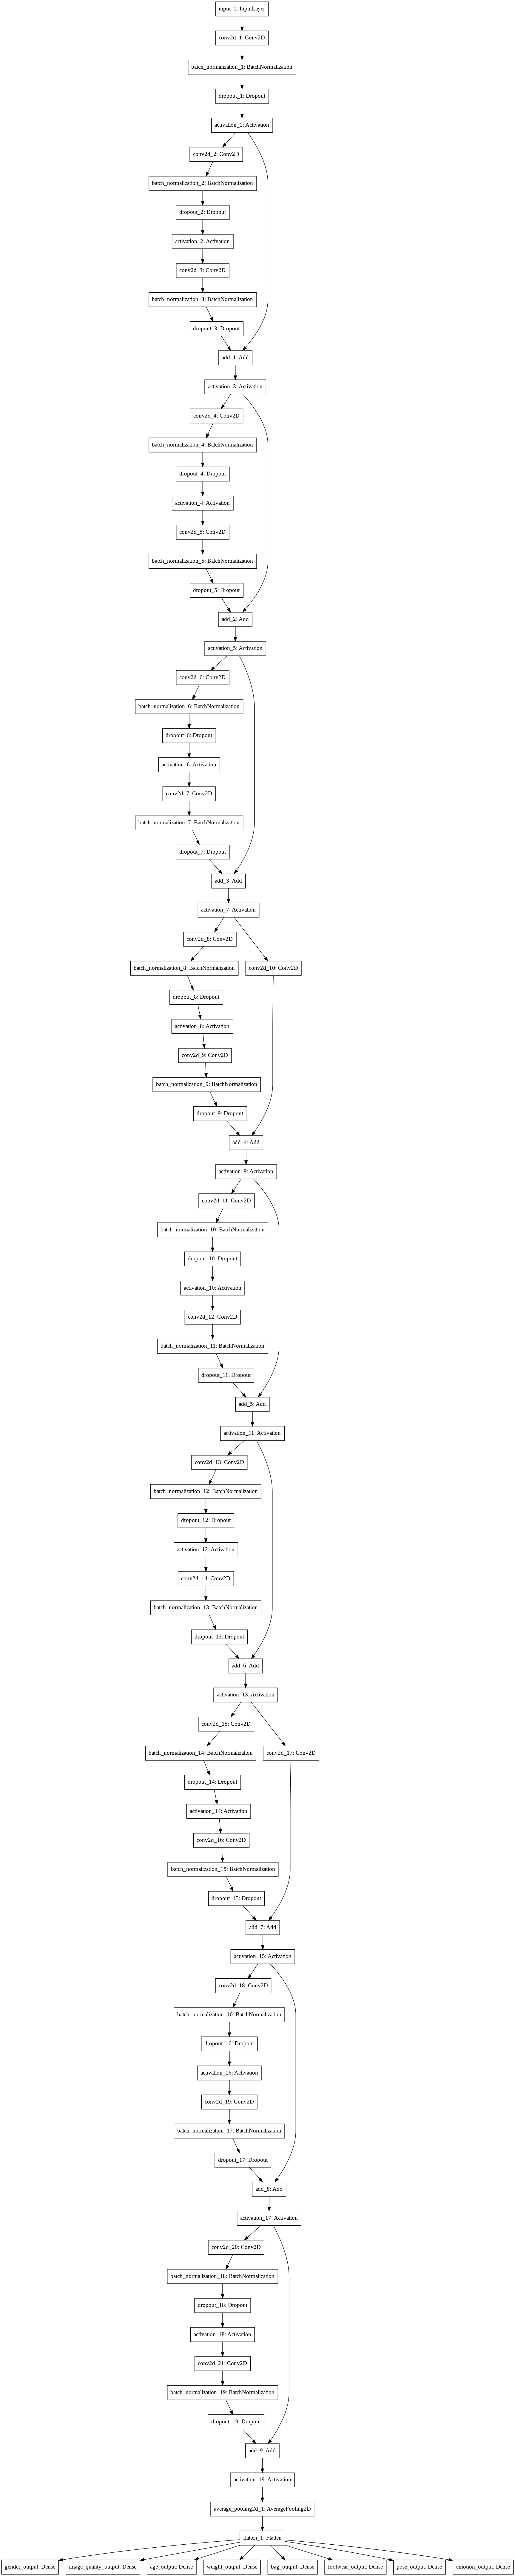

In [33]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [0]:
# model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=32, epochs=10)

In [35]:
model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=50,
    verbose=1,
    callbacks=callbacks
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
Learning rate:  0.001
360/360 [==============================] - 132s 368ms/step - loss: 8.0541 - gender_output_loss: 0.6817 - image_quality_output_loss: 0.9648 - age_output_loss: 1.4481 - weight_output_loss: 1.0189 - bag_output_loss: 0.9197 - footwear_output_loss: 0.9941 - pose_output_loss: 0.9429 - emotion_output_loss: 0.9273 - gender_output_acc: 0.5704 - image_quality_output_acc: 0.5459 - age_output_acc: 0.4024 - weight_output_acc: 0.6179 - bag_output_acc: 0.5528 - footwear_output_acc: 0.5198 - pose_output_acc: 0.6076 - emotion_output_acc: 0.7056 - val_loss: 8.0583 - val_gender_output_loss: 0.6783 - val_image_quality_output_loss: 0.9708 - val_age_output_loss: 1.4486 - val_weight_output_loss: 0.9888 - val_bag_output_loss: 0.9340 - val_footwear_output_loss: 0.9714 - val_pose_output_loss: 0.9286 - val_emotion_output_loss: 0.9815 - val_gender_output_acc: 0.5962 - val_image_quality_

In [0]:
def evaluate_model(model):
    results = model.evaluate_generator(valid_gen, verbose=1)
    accuracies = {}
    losses = {}
    for k, v in zip(model.metrics_names, results):
        print(k)
        if (k.endswith('acc')):
            accuracies[k] = round(v * 100, 4) 
        else:
            losses[k] = v
    return accuracies

In [37]:
evaluate_model(model) 

63/63 [==============================] - 5s 84ms/step
loss
gender_output_loss
image_quality_output_loss
age_output_loss
weight_output_loss
bag_output_loss
footwear_output_loss
pose_output_loss
emotion_output_loss
gender_output_acc
image_quality_output_acc
age_output_acc
weight_output_acc
bag_output_acc
footwear_output_acc
pose_output_acc
emotion_output_acc


{'age_output_acc': 36.5575,
 'bag_output_acc': 58.9782,
 'emotion_output_acc': 68.5516,
 'footwear_output_acc': 60.6151,
 'gender_output_acc': 72.5198,
 'image_quality_output_acc': 58.4325,
 'pose_output_acc': 61.4087,
 'weight_output_acc': 63.9881}